In [1]:
import numpy as np
import pandas as pd
%pylab inline
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10,5
from pandas import Series
import matplotlib.pyplot as plt
from pandas import concat
import seaborn as sns
from pandas import DataFrame
from pandas.plotting import lag_plot
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from sklearn.cluster import DBSCAN
sns.set()

Populating the interactive namespace from numpy and matplotlib


In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

In [3]:
df = pd.read_csv('ibm_daily_1962-2018.csv', parse_dates=True,index_col='Date',date_parser=dateparse,header = 0, sep="\t")
df.head()

,Open,High,Low,Close,Adj,Volume
Date,,,,,,
1962-01-02,7.713333,7.713333,7.626667,7.626667,0.689273,387200
1962-01-03,7.626667,7.693333,7.626667,7.693333,0.695299,288000
1962-01-04,7.693333,7.693333,7.613333,7.616667,0.688370,256000
1962-01-05,7.606667,7.606667,7.453333,7.466667,0.674813,363200
1962-01-08,7.460000,7.460000,7.266667,7.326667,0.662160,544000


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14168 entries, 1962-01-02 to 2018-04-13
Data columns (total 6 columns):
Open      14168 non-null float64
High      14168 non-null float64
Low       14168 non-null float64
Close     14168 non-null float64
Adj       14168 non-null float64
Volume    14168 non-null int64
dtypes: float64(5), int64(1)
memory usage: 774.8 KB


In [50]:
df.describe()

,Open,High,Low,Close,Adj,Volume
count,14168.000000,14168.000000,14168.000000,14168.000000,14168.000000,1.416800e+04
mean,57.438904,57.976158,56.934359,57.459656,40.174300,4.867323e+06
std,56.427873,56.889503,56.005953,56.457842,53.133012,4.529909e+06
min,4.080000,4.286667,4.000000,4.080000,0.368845,0.000000e+00
25%,15.967187,16.093750,15.843750,15.953125,1.808643,1.240000e+06
50%,27.843750,28.125000,27.625000,27.875000,7.404912,4.123400e+06
75%,93.757500,94.739998,92.757500,93.699997,70.678108,6.888075e+06
max,215.380005,215.899994,214.300003,215.800003,184.557632,6.944470e+07


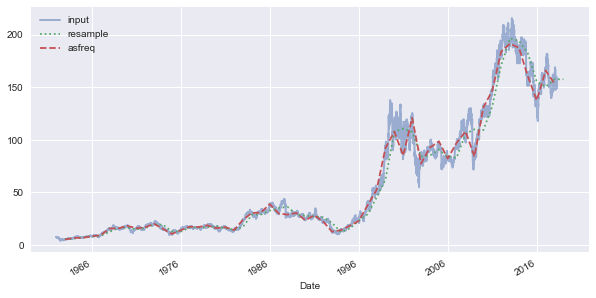

In [51]:
#PLOT
cl = df['Close']
plt.xlabel('Year', fontsize=10);
cl.plot(alpha=0.5, style='-',linewidth=2, fontsize=10)
cl.resample('BA').mean().plot(style=':')
cl.asfreq('BA').plot(style='--');
plt.legend(['input', 'resample', 'asfreq'],
           loc='upper left');


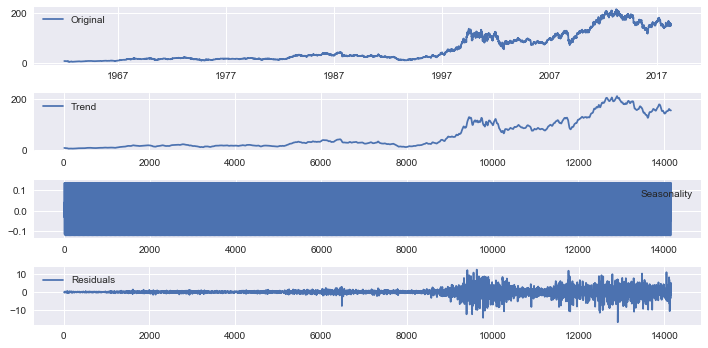

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(cl.values, freq=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(cl, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


/Users/ludovicavasile/anaconda3/envs/py27/lib/python2.7/site-packages/pandas/core/series.py:2849: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)
/Users/ludovicavasile/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  """


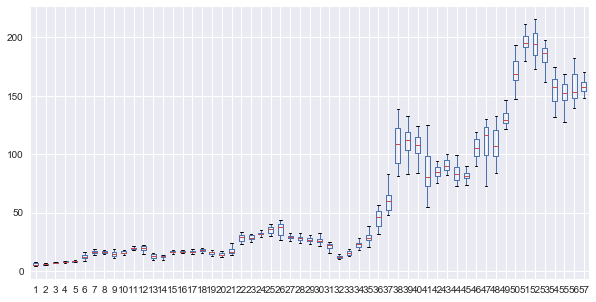

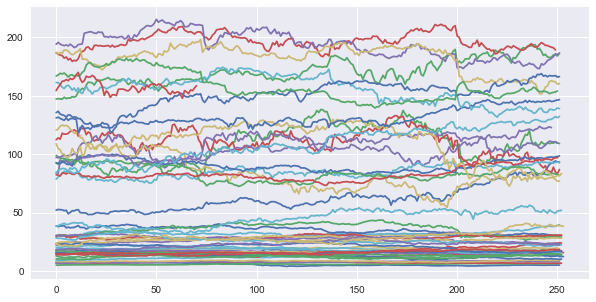

In [8]:
#SPLIT INTO YEARS
series = pd.Series.from_csv('ibm_daily_1962-2018.csv',sep="\t", header = 0)
from pandas import TimeGrouper
from pandas import DataFrame
groups = series.groupby(TimeGrouper('Y'))
years = concat([DataFrame(x[1].values) for x in groups], axis=1)
years = DataFrame(years)
years.columns = range(1,58)
years.boxplot()
years.plot(legend=False)

## Transformation II: Amplitude Scaling
Normalize the amplitude (divide by the standard deviation of the series)
## Transformation IV: Noise (smoothing)
By smoothing with a very large window we obtain a (non-linear, non-parametric) trend line, that we can subtract to the original time series.

(254, 71)


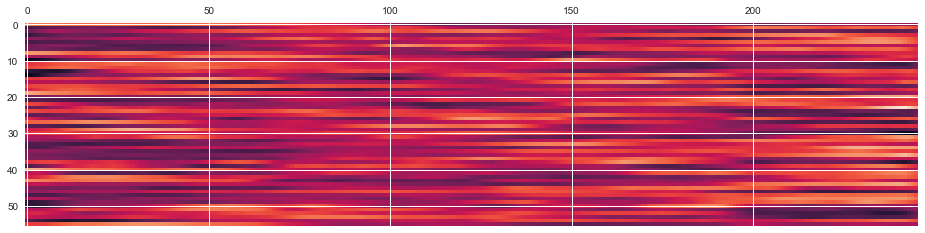

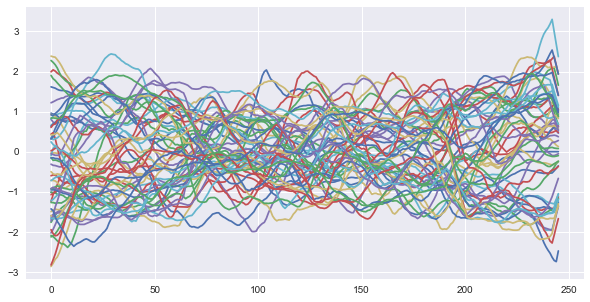

In [9]:
mm = DataFrame()
i = 0
max = np.amax([len(x[1].values) for x in groups])
min =np.amin([len(x[1].values) for x in groups])
for name, group in groups:
    if(len(group) > min):       #rimuovo osservazioni non necessarie
        norm_values = (group.values - mean(group.values)) / std(group.values)
        # Padding performed to have series of same length -- important only for plotting the matrix
        pad_values = np.pad(norm_values,(0,max+1 -len(norm_values)),'constant',constant_values=mean(norm_values))
        mm["%s" % (name.year)] = pad_values
        mm["%s" % (name.year)] = mm["%s" % (name.year)].rolling(window=10).mean()
      #  mm["%s" % (name.year)].fillna( mm["%s" % (name.year)].mean(), inplace=True)
mm.dropna(inplace=True)
mm = mm.reset_index(drop=True)
matshow(mm.T, interpolation=None, aspect='auto')
mm.plot(legend=False)
print(max,min)


In [10]:
mm

,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,1.617726,-1.762635,-1.238907,-2.025913,-0.713271,-1.696871,-1.017268e+00,-1.007967,1.994881,-0.313005,...,-0.499346,-1.664714,-0.158802,-2.125817,-1.946564,-0.054175,0.420804,0.244647,-1.427635,0.839284
1,1.602423,-1.672967,-1.068792,-1.937264,-0.718722,-1.678246,-1.026736e+00,-1.031040,2.041980,-0.340210,...,-0.553921,-1.659527,-0.152417,-2.101415,-2.045373,-0.072972,0.423622,0.179455,-1.474053,0.843016
2,1.585285,-1.586044,-0.958718,-1.825055,-0.730531,-1.649593,-1.020819e+00,-1.027579,2.011851,-0.346124,...,-0.571372,-1.671486,-0.169727,-2.048125,-2.099503,-0.089340,0.443089,0.139678,-1.628777,0.836298
3,1.555905,-1.524741,-0.819457,-1.703661,-0.766867,-1.612343,-9.799894e-01,-1.062189,1.961289,-0.362684,...,-0.554291,-1.677394,-0.172707,-1.980905,-2.085756,-0.090779,0.470219,0.081884,-1.739367,0.824355
4,1.534482,-1.468012,-0.684366,-1.599837,-0.828639,-1.584048,-9.066150e-01,-1.073726,1.928043,-0.378061,...,-0.564774,-1.662985,-0.189733,-1.894239,-2.035349,-0.082145,0.425208,0.036101,-1.815715,0.835884
5,1.527137,-1.405794,-0.564285,-1.518376,-0.875877,-1.566497,-8.474421e-01,-1.079495,1.889948,-0.378653,...,-0.567364,-1.658734,-0.228610,-1.832254,-1.943270,0.013009,0.355621,0.025569,-1.909395,0.851559
6,1.527443,-1.364620,-0.452543,-1.451290,-0.896771,-1.551454,-8.255482e-01,-1.100261,1.852546,-0.341984,...,-0.514208,-1.639137,-0.301540,-1.723524,-1.827277,0.106814,0.287180,0.024177,-1.990224,0.920232
7,1.515201,-1.329851,-0.382495,-1.377016,-0.909488,-1.536411,-7.693339e-01,-1.144100,1.810988,-0.292305,...,-0.450075,-1.587264,-0.347086,-1.597591,-1.668896,0.212940,0.210546,-0.011161,-2.082552,1.019841
8,1.504796,-1.295081,-0.339133,-1.310729,-0.868610,-1.533546,-7.498069e-01,-1.162559,1.750037,-0.243808,...,-0.417762,-1.535390,-0.394760,-1.471939,-1.552186,0.309174,0.138229,-0.039536,-2.186040,1.108585
9,1.480312,-1.251162,-0.329126,-1.235656,-0.836815,-1.526382,-7.356054e-01,-1.163713,1.670038,-0.218377,...,-0.414741,-1.467810,-0.483156,-1.361526,-1.410273,0.412782,0.058249,-0.069825,-2.259174,1.183312


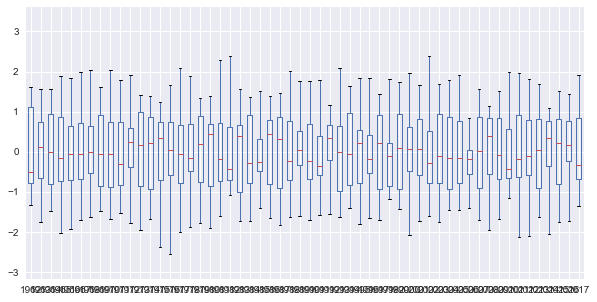

In [11]:
mm.boxplot()

In [12]:
len(mm.columns)

56

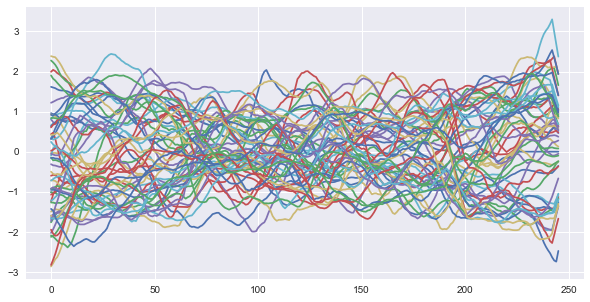

In [13]:
#for x in list(mm.columns):
    #plot(mm.loc[:, x])
plot(mm)

## Lag plot
If the points cluster along a diagonal line from the bottom-left to the top-right of the plot, it suggests a positive correlation relationship.
If the points cluster along a diagonal line from the top-left to the bottom-right, it suggests a negative correlation relationship.
Either relationship is good as they can be modeled.

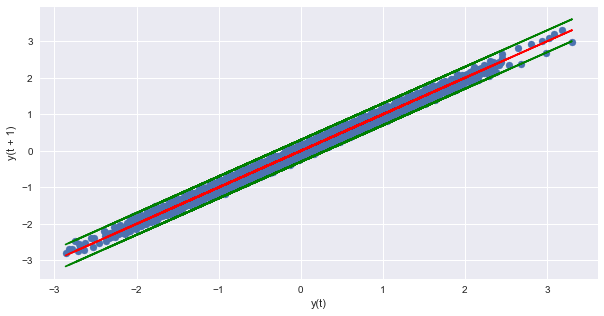

In [14]:
#for x in list(mm.columns):
    #lag_plot( mm.loc[:, x] )
    #plot(mm.loc[:, x], mm.loc[:, x], 'r-')
    #plot(mm.loc[:, x], mm.loc[:, x]+0.3, 'g-')
    #plot(mm.loc[:, x], mm.loc[:, x]-0.3, 'g-')
lag_plot(mm)
plot(mm, mm, 'r-')
plot(mm, mm+0.3, 'g-')
plot(mm, mm-0.3, 'g-')

/Users/ludovicavasile/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  """Entry point for launching an IPython kernel.


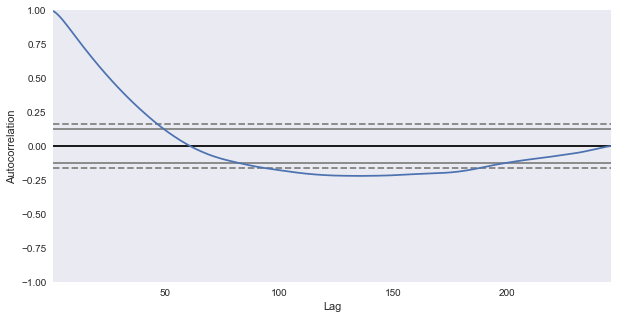

In [15]:
autocorrelation_plot(mm)

In [16]:
def dtw(x, y, dist):
    """
    Computes Dynamic Time Warping (DTW) of two sequences.

    :param array x: N1*M array
    :param array y: N2*M array
    :param func dist: distance used as cost measure

    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    r, c = len(x), len(y)
    
    # D0 = D1 = matrix of point-to-point costs
    D0 = zeros((r + 1, c + 1))
    D0[0, 1:] = inf
    D0[1:, 0] = inf
    D1 = D0[1:, 1:] # view (hide first column and first row)
    
    # Fill the point-to-point costs matrix
    for i in range(r):
        for j in range(c):
            D1[i, j] = dist(x[i], y[j])
     
    # C = matrix of optimal paths costs
    C = D1.copy()
    for i in range(r):
        for j in range(c):
            D1[i, j] += np.array([D0[i, j], D0[i, j+1], D0[i+1, j]]).min()
    
    # Infer the path from matrix C
    if len(x)==1:
        path = zeros(len(y)), range(len(y))  # special case 1
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))  # special case 2
    else:
        path = _traceback(D0)  # general case
        
    return D1[-1, -1], C, D1, path

# Function for inferring the optima path (general case)
# Starts from last cell and goes backward...
def _traceback(D):
    i, j = array(D.shape) - 2
    p, q = [i], [j]
    while ((i > 0) or (j > 0)):
        tb = argmin((D[i, j], D[i, j+1], D[i+1, j]))
        if (tb == 0):
            i -= 1
            j -= 1
        elif (tb == 1):
            i -= 1
        else: # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return array(p), array(q)

In [17]:
def distance(x,y):
    return abs(x-y)

In [18]:
mm.keys()

Index([u'1962', u'1963', u'1964', u'1965', u'1966', u'1967', u'1968', u'1969',
       u'1970', u'1971', u'1972', u'1973', u'1974', u'1975', u'1976', u'1977',
       u'1978', u'1979', u'1980', u'1981', u'1982', u'1983', u'1984', u'1985',
       u'1986', u'1987', u'1988', u'1989', u'1990', u'1991', u'1992', u'1993',
       u'1994', u'1995', u'1996', u'1997', u'1998', u'1999', u'2000', u'2001',
       u'2002', u'2003', u'2004', u'2005', u'2006', u'2007', u'2008', u'2009',
       u'2010', u'2011', u'2012', u'2013', u'2014', u'2015', u'2016', u'2017'],
      dtype='object')

In [19]:
#numpy.savetxt("ibm_for_euclidean.csv", mm, delimiter=",")

In [20]:
%%time
# CAUTION !!! CAN BE VERY SLOW !!!
years_list = mm.keys()
# Compute upper half of matrix
dd1 = [ [ (dtw(mm[years_list[x]],mm[years_list[y]],distance)[0] \
           if y > x else -1)  \
         for y in range(len(years_list)) ] 
       for x in range(len(years_list)) ]
# Copy values also to the lower half, exployting symmetry of the distance function
dd2 = [ [ (dd1[x][y] if y > x else dd1[y][x])  for y in range(len(years_list)) ] for x in range(len(years_list)) ]
# Finally, the diagonal
for i in range(len(years_list)):
    dd2[i][i] = 0.0

CPU times: user 41min 12s, sys: 26.2 s, total: 41min 39s
Wall time: 41min 41s


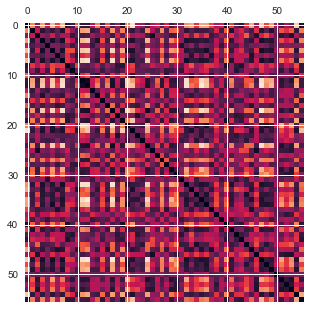

In [21]:
#Plot the matrix of distances
matshow(dd2, interpolation=None, aspect='auto')

In [22]:
#numpy.savetxt("matrix.csv", dd2, delimiter=",")

In [23]:
#Clustering with DBSCAN using a pre-computed distance matrix (dd2)

from scipy.stats import itemfreq

db = DBSCAN(eps=32.5, min_samples=2, metric='precomputed').fit(dd2)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

print('Number of clusters found: %d' % n_clusters_)
print(itemfreq(db.labels_))

cluster_sets = [ (l_,years_list[db.labels_ == l_]) for l_ in set(db.labels_) ]
for pp in cluster_sets:
    print(pp[0], "\t--> ", list(pp[1]))

Number of clusters found: 8
[[-1 27]
 [ 0  4]
 [ 1  3]
 [ 2  9]
 [ 3  3]
 [ 4  4]
 [ 5  2]
 [ 6  2]
 [ 7  2]]
(0, '\t--> ', ['1962', '1970', '1981', '2002'])
(1, '\t--> ', ['1964', '1987', '2008'])
(2, '\t--> ', ['1965', '1967', '1969', '1982', '1994', '1997', '1998', '2009', '2010'])
(3, '\t--> ', ['1968', '1999', '2007'])
(4, '\t--> ', ['1973', '1974', '1979', '1986'])
(5, '\t--> ', ['1983', '1995'])
(6, '\t--> ', ['1996', '2006'])
(7, '\t--> ', ['2013', '2015'])
(-1, '\t--> ', ['1963', '1966', '1971', '1972', '1975', '1976', '1977', '1978', '1980', '1984', '1985', '1988', '1989', '1990', '1991', '1992', '1993', '2000', '2001', '2003', '2004', '2005', '2011', '2012', '2014', '2016', '2017'])


Text(0.5,1,u'Cluster 0')

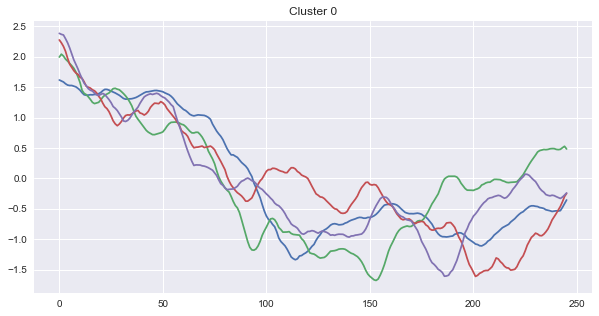

In [41]:
plot(mm['1962'])
plot(mm['1970'])
plot(mm['1981'])
plot(mm['2002'])
plt.title('Cluster 0')

Text(0.5,1,u'Cluster 1')

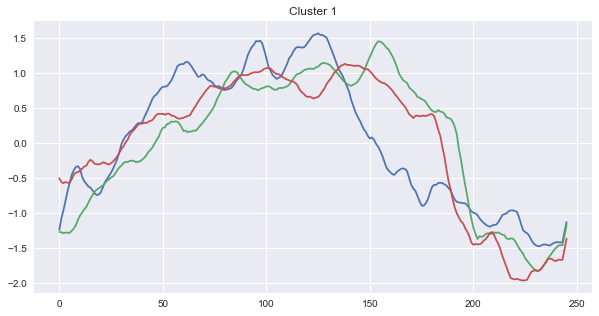

In [42]:
plot(mm['1964'])
plot(mm['1987'])
plot(mm['2008'])
plt.title('Cluster 1')

Text(0.5,1,u'Cluster 2')

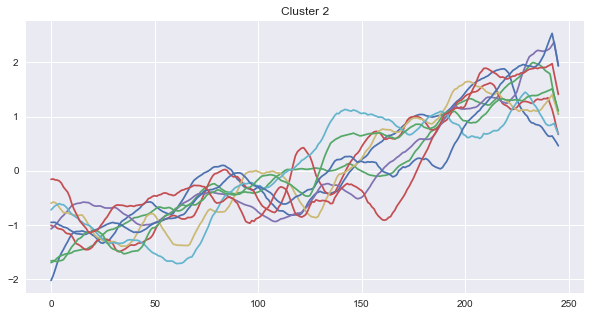

In [43]:
plot(mm['1965'])
plot(mm['1967'])
plot(mm['1969'])
plot(mm['1982'])
plot(mm['1994'])
plot(mm['1997'])
plot(mm['1998'])
plot(mm['2009'])
plot(mm['2010'])
plt.title('Cluster 2')

Text(0.5,1,u'Cluster 3')

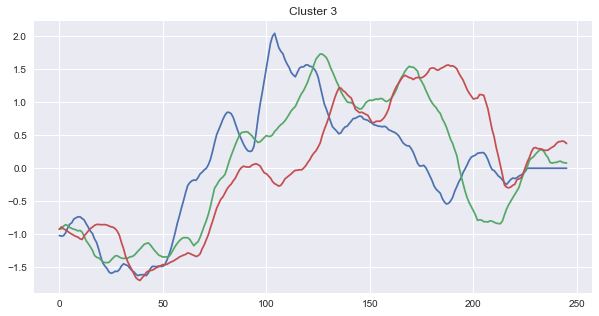

In [44]:
plot(mm['1968'])
plot(mm['1999'])
plot(mm['2007'])
plt.title('Cluster 3')

Text(0.5,1,u'Cluster 4')

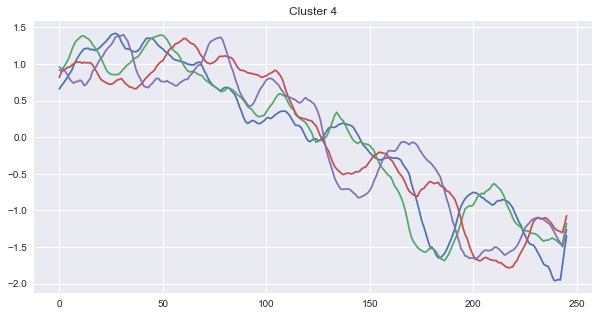

In [45]:
plot(mm['1973'])
plot(mm['1974'])
plot(mm['1979'])
plot(mm['1986'])
plt.title('Cluster 4')

Text(0.5,1,u'Cluster 5')

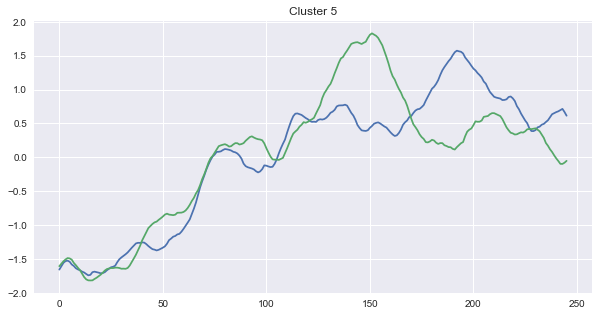

In [46]:
plot(mm['1983'])
plot(mm['1995'])
plt.title('Cluster 5')

Text(0.5,1,u'Cluster 6')

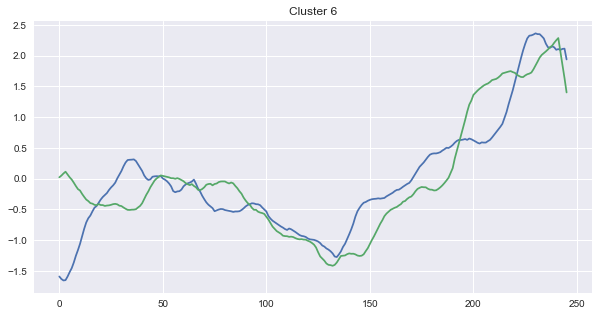

In [47]:
plot(mm['1996'])
plot(mm['2006'])
plt.title('Cluster 6')

Text(0.5,1,u'Cluster 7')

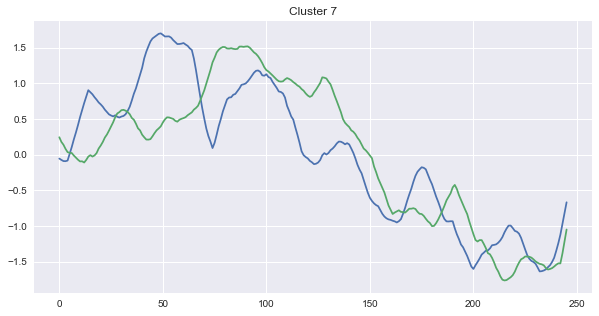

In [48]:
plot(mm['2013'])
plot(mm['2015'])
plt.title('Cluster 7')

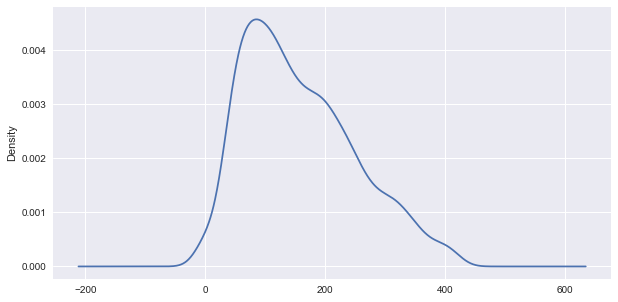

In [25]:
#Plot the distribution of distances to understand what range of values for eps could make sense
from pandas import Series
Series(reshape(dd2,(1,56*56))[0]).plot(kind='kde')
pyplot.grid(True)

Text(0.5,1,u'N. clusters (green) and noise size (blue) vs. eps')

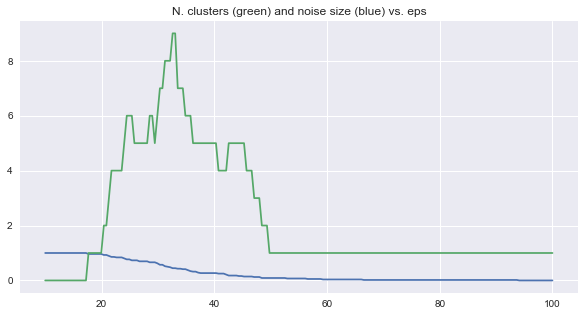

In [26]:
#run the clustering with several different values of eps
#and plot the results (number of clusters and size of noise) to choose a good threshold to use above

eps_list = linspace(10.0,100.0,num=200)
#eps_list = linspace(0.78,0.8,num=200)
noise_list = array([])
n_clusters_list = array([])
for myeps in eps_list:
    db = DBSCAN(myeps, min_samples=2, metric='precomputed').fit(dd2)
    noise_list = append(noise_list, sum([ 1 if i==-1 else 0 for i in db.labels_]))
    n_clusters_list = append(n_clusters_list, len(set(db.labels_)) - (1 if -1 in db.labels_ else 0))
plot(eps_list, noise_list/56)
plot(eps_list, n_clusters_list)
pyplot.grid(True)
pyplot.title("N. clusters (green) and noise size (blue) vs. eps")
#plot([0.8,0.8],[0,5],'r-')

('Stress value: ', 1152589.7543889573)


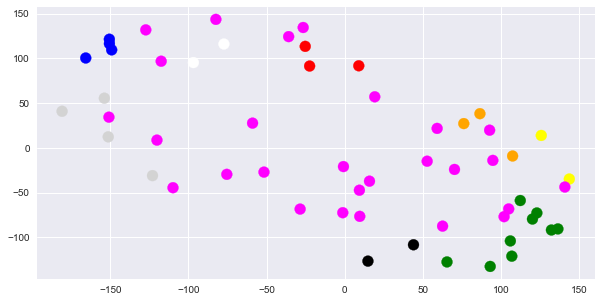

In [27]:
#Visualizing clusters

#nuovo valore di eps in base al grafico precedente = 32.5

from sklearn import manifold
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(dd2)
print("Stress value: ", pos.stress_)

# Assign colors based on clusters
db = DBSCAN(eps=32.5, min_samples=2, metric='precomputed').fit(dd2)
cols = ['lightgray', 'red', 'green', 'orange', 'blue', 'yellow', 'black', 'white', 'magenta']
cc = [ cols[l] for l in db.labels_]
#cc = [ cols[l+1] for l in db.labels_]
scatter(pos.embedding_.T[0], pos.embedding_.T[1], color=cc, s=120)

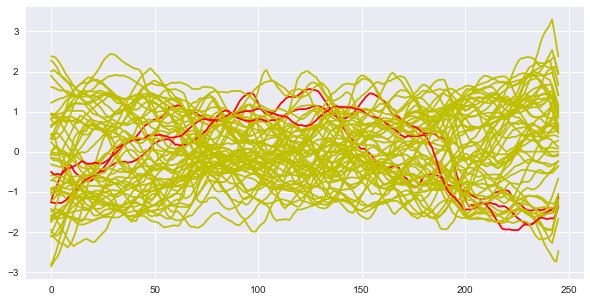

In [28]:
#Method 2: plot time series with colors

for i in range(len(db.labels_)):
    plot(mm[years_list[i]],'r-' if db.labels_[i]==1 else 'y-')

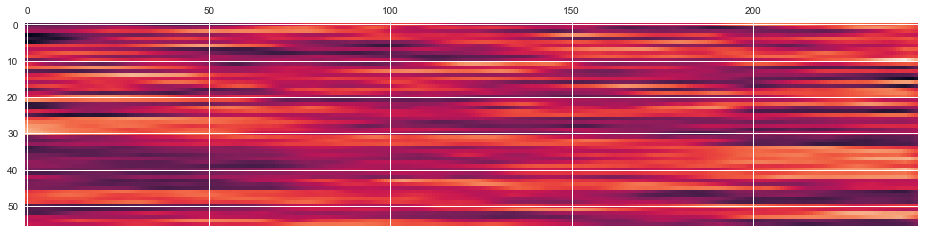

In [29]:
#Method 3: heatmaps, sorting the rows based on clusters
from operator import itemgetter
mm_sort=sorted(zip(array(mm.T),db.labels_),key=itemgetter(1))
mm_sort2=[el[0] for el in mm_sort]
matshow(mm_sort2, interpolation=None, aspect='auto')

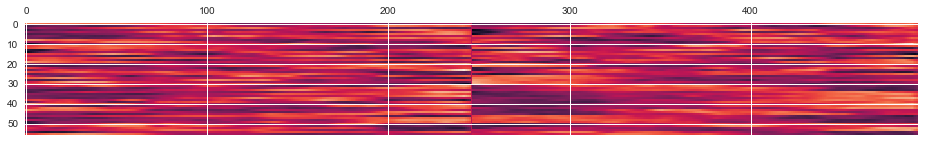

In [30]:
#comparing against original data ordering
before = mm.T
after = mm_sort2
separator = array([[ 0 ] * 56]).T
matshow(hstack((before, separator, after)), interpolation=None, aspect='auto')

# Using Euclidean distance
Simply adopt the following function instead of our dtw. Just take care of putting the list of numbers inside a double square parenthesis: [[ 1,2,3 ]] and not [ 1,2,3 ].

In [31]:
from sklearn.metrics.pairwise import euclidean_distances

...

# Features_extraction

In [32]:
from scipy.stats import kurtosis, skew
feat = [ [ mean(day), std(day), skew(day), kurtosis(day), 
           mean(day[1:]-day[:-1]), skew(day[1:]-day[:-1]), kurtosis(day[1:]-day[:-1]) ]
    for day in array(mm.T) ]

In [33]:
norm_feat = transpose([ (attr-mean(attr))/std(attr)  for attr in transpose(feat) ])

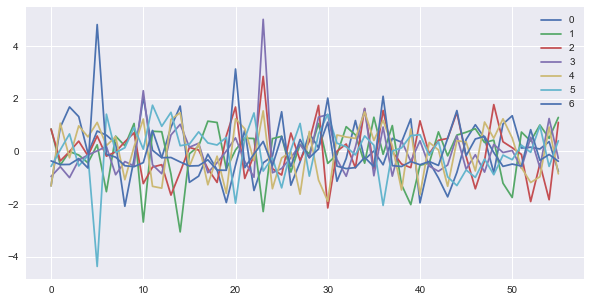

In [34]:
plot(norm_feat)
legend(range(len(feat[0])))

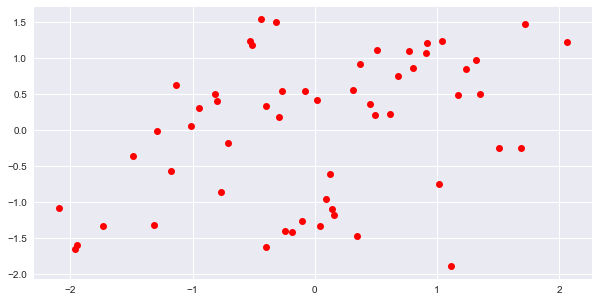

In [35]:
plot(transpose(norm_feat)[0], transpose(norm_feat)[4],'or')
grid(True)

In [36]:
#KMeans
from sklearn.cluster import KMeans
km2 = KMeans(n_clusters=10)
km2.fit(norm_feat)

from scipy.stats import itemfreq
print itemfreq(km2.labels_)

[[ 0 16]
 [ 1  9]
 [ 2  1]
 [ 3  3]
 [ 4  8]
 [ 5  2]
 [ 6  7]
 [ 7  1]
 [ 8  5]
 [ 9  4]]


Text(0.5,1.05,u'Original order (by date)')

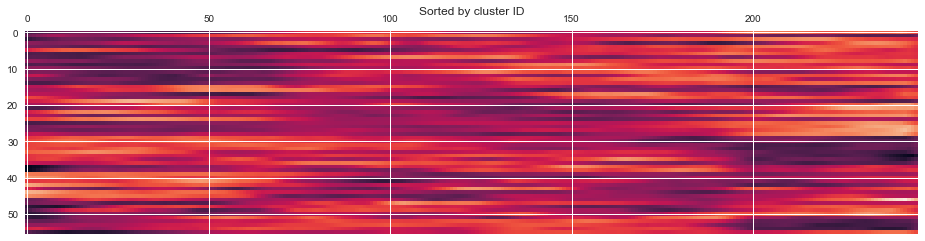

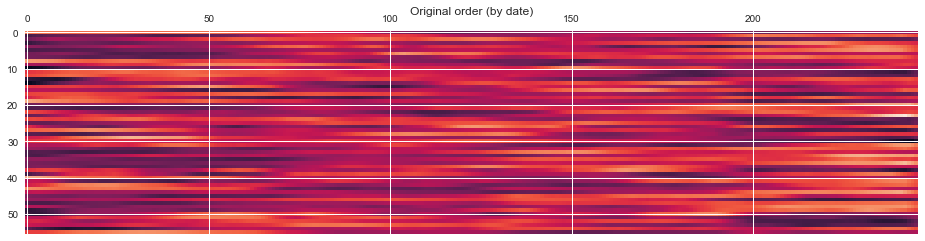

In [37]:
from operator import itemgetter
mm_sort=sorted(zip(array(mm.T),km2.labels_),key=itemgetter(1))
mm_sort2=[el[0] for el in mm_sort]
matshow(mm_sort2, interpolation=None, aspect='auto')
title('Sorted by cluster ID')
matshow(mm.T, interpolation=None, aspect='auto')
title('Original order (by date)')